##Description:

 Code for RhizCG microbial community analysis to be presented at ESA, August 12th, 2015



# Setting variables

In [1]:
workDir = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/ordination/ord_raw/'
biomFileDir = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTU_binning/'

biomFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTU_binning/otu_table_wtax.biom'
metadataFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/metadata_RhizCG_merged.txt'
treeFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/fasttree/otusn.tree'

# Init

In [2]:
import os
from pandas import DataFrame
from IPython.display import FileLink

In [3]:
%matplotlib inline
%load_ext rpy2.ipython

In [4]:
%%R

library(phyloseq)
library(ggplot2)
library(foreach)
library(doParallel)
library(gridExtra)
library(dplyr)
library(tidyr)
library(vegan)
library(DESeq2)



foreach: simple, scalable parallel programming from Revolution Analytics
Use Revolution R for scalability, fault tolerance and more.
http://www.revolutionanalytics.com
Loading required package: iterators
Loading required package: parallel
Loading required package: grid

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: permute
Loading required package: lattice
This is vegan 2.3-0
Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parR

In [5]:
if not os.path.isdir(workDir):
    os.mkdir(workDir)

# Setting files

In [6]:
!cd $workDir; ln -f -s $biomFileDir$biomFile
!cd $workDir; ln -f -s $biomFileDir'../'$metadataFile
!cd $workDir; ls -thlc

total 32K
lrwxrwxrwx 1 bryan bryan 130 Aug  9 13:22 metadata_RhizCG_merged.txt -> /home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTU_binning/..//home/bryan/RhizCG/data/MiSeq_amplicon/metadata_RhizCG_merged.txt
lrwxrwxrwx 1 bryan bryan 143 Aug  9 13:22 otu_table_wtax.biom -> /home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTU_binning//home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTU_binning/otu_table_wtax.biom
-rw-rw-r-- 1 bryan bryan 22K Jul 27 13:53 heatmap_rank2.pdf


# Loading/editting OTU table

In [7]:
%%R -i biomFile -i metadataFile -i workDir -i treeFile
# loading
setwd(workDir)

## biom file
physeq = import_biom(biomFile, treeFile)

## loading sample metadata
sample.data = import_qiime_sample_data(metadataFile)
physeq = merge_phyloseq(physeq,sample.data)

#apply gsub across columns to replace ___ w/ "", reload to phyloseq object
t = tax_table(physeq)
t = apply(t, 2, function(y) gsub("__", "", y))
tax_table(physeq) = t

In [8]:
%%R
plantData = read.table('/home/bryan/RhizCG/data/MiSeq_amplicon/PlotData.txt', header = TRUE)

s = sample_data(physeq)
enz = plantData[,c(1,31:55)]
s2 = left_join(s, enz, by = c("X.sample" = "Unique"))
rownames(s2) = s2$X.sample
sample_data(physeq) = s2
sample_data(physeq) %>% head

Sample Data:        [6 samples by 46 sample variables]:
                           X.sample Library Primer_Plate Primer_Well_ID
sample2-1.06_Npos sample2-1.06_Npos       1            1             H9
sample6-4.27_Npos sample6-4.27_Npos       1            2            F11
sample4-4.27_Nneg sample4-4.27_Nneg       1            1            B12
sample4-1.06_Nneg sample4-1.06_Nneg       1            1            E11
sample2-1.06_Nneg sample2-1.06_Nneg       1            1             G9
sample6-3.07_Nneg sample6-3.07_Nneg       1            2            C11
                  primerFR_ID_byPlate primerFR_ID_total barcode_ID    PlotID
sample2-1.06_Npos                  72                72         72 1.06_Npos
sample6-4.27_Npos                  86               182        182 4.27_Npos
sample4-4.27_Nneg                  90                90         90 4.27_Nneg
sample4-1.06_Nneg                  85                85         85 1.06_Nneg
sample2-1.06_Nneg                  71                71

In [9]:
%%R
#subset out positive and negative controls
physeq = subset_samples(physeq, !is.na(DAP))
#set DAP to factor
sample_data(physeq)$DAP = factor(sample_data(physeq)$DAP)
print(physeq)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 11246 taxa and 240 samples ]
sample_data() Sample Data:       [ 240 samples by 46 sample variables ]
tax_table()   Taxonomy Table:    [ 11246 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 11246 tips and 11245 internal nodes ]


##Normalize samples and filter out taxa that are less than .1*length(x)

In [10]:
%%R 
# filtering/normalizing
physeq.snorm = prune_samples(sample_sums(physeq) >= 10, physeq)
physeq.snorm = transform_sample_counts(physeq.snorm, function(x) x/sum(x))
  
physeq.thresh = filter_taxa(physeq.snorm, function(x) sum(x > 0) > (0.1 * length(x)), TRUE)
print(physeq.snorm)
#physeq.thresh = physeq.snorm

print(physeq.thresh)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 11246 taxa and 240 samples ]
sample_data() Sample Data:       [ 240 samples by 46 sample variables ]
tax_table()   Taxonomy Table:    [ 11246 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 11246 tips and 11245 internal nodes ]
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 6736 taxa and 240 samples ]
sample_data() Sample Data:       [ 240 samples by 46 sample variables ]
tax_table()   Taxonomy Table:    [ 6736 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 6736 tips and 6735 internal nodes ]


Notes: Threshold of 0.0001*length(x) removes 9 taxa, 0.01*length(x) results in 10493 taxa, 0.1*length results in 6736 taxa

## Calculate pairwise weighted Unifrac distances between samples

In [25]:
%%R
registerDoParallel(cores=28)
full.wunif.dist = phyloseq::distance(physeq.thresh, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

In [27]:
%%R
registerDoParallel(cores=28)
full.bray.dist = phyloseq::distance(physeq.thresh, 
                      method = "bray", 
                      parallel = TRUE, 
                      normalized = FALSE)

## NMDS of w-unif

Run 0 stress 0.1403636 
Run 1 stress 0.1419805 
Run 2 stress 0.1537617 
Run 3 stress 0.1420143 
Run 4 stress 0.1537552 
Run 5 stress 0.1432434 
Run 6 stress 0.1720734 
Run 7 stress 0.140356 
... New best solution
... procrustes: rmse 0.001666789  max resid 0.02514259 
Run 8 stress 0.1652872 
Run 9 stress 0.1420411 
Run 10 stress 0.1432582 
Run 11 stress 0.1616583 
Run 12 stress 0.170004 
Run 13 stress 0.1777276 
Run 14 stress 0.1462743 
Run 15 stress 0.1450887 
Run 16 stress 0.1419673 
Run 17 stress 0.150127 
Run 18 stress 0.1734873 
Run 19 stress 0.1688863 
Run 20 stress 0.178316 
Saving 8.33 x 4.86 in image


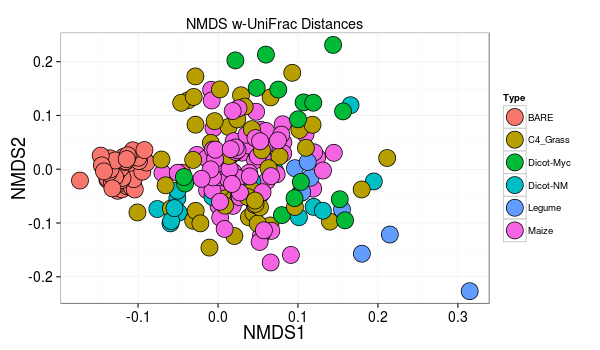

In [42]:
%%R -w 600 -h 350

nmds = ordinate(physeq.thresh, 
                method = "NMDS", 
                distance = full.wunif.dist)

p = plot_ordination(physeq.thresh, nmds, justDF = TRUE)

## generating plots
p1 = ggplot(p, aes(x = NMDS1, y = NMDS2)) +
        geom_point(aes(fill=Type), pch = 21, size = 8) +
        theme_bw() +
        theme(axis.text = element_text(size = 14), 
              axis.title = element_text(size = 18)) +
        labs(title = "NMDS w-UniFrac Distances", size = 20)
        #scale_size(range=c(2,8))

##need arrange into a presentation quality graphic and save

grid.arrange(p1, ncol=1)
ggsave(filename = "NMDS_full_wunif.pdf", plot = p1)

Error in layout_base(data, vars, drop = drop) : 
  At least one layer must contain all variables used for facetting


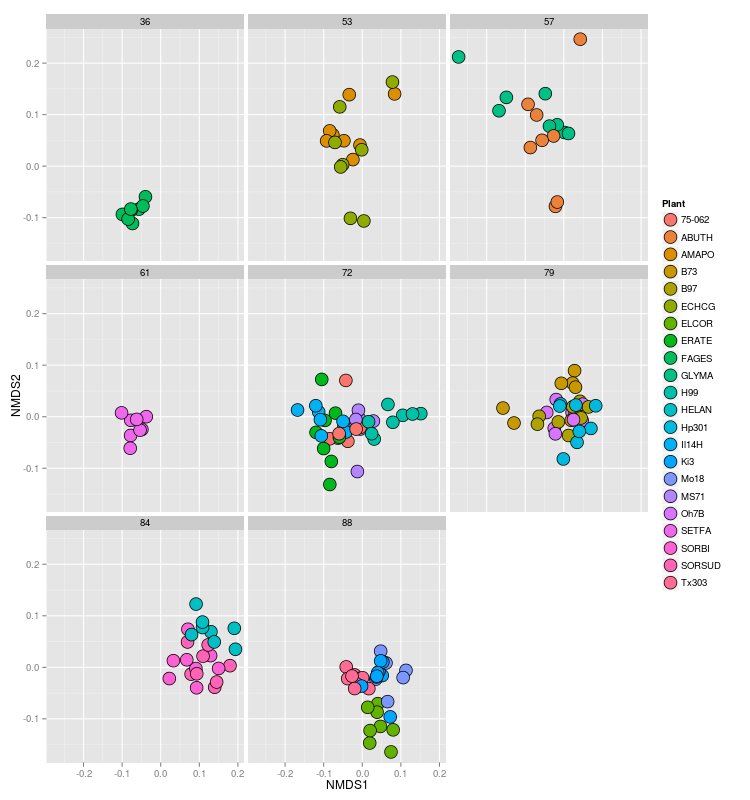

In [67]:
%%R -w 750 -h 800


## generating plots
p1 = ggplot(p, aes(x = NMDS1, y = NMDS2)) +
        geom_point(aes(fill=Plant), size = 6, pch=21) +
        facet_wrap(~ DAP) +
        scale_size(range=c(2,8))

p1

##Subset just plants to evaluate variation without bare soil

In [30]:
%%R

physeq.plant = subset_samples(physeq.thresh, Plant != "BARE")
physeq.plant

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 6736 taxa and 176 samples ]
sample_data() Sample Data:       [ 176 samples by 46 sample variables ]
tax_table()   Taxonomy Table:    [ 6736 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 6736 tips and 6735 internal nodes ]


In [31]:
%%R
#create maize/non-maize variable
sample_data(physeq.plant)$Maize = ifelse(sample_data(physeq.plant)$Type == "Maize", "Maize", 
                                         "Annuals")

In [38]:
%%R
registerDoParallel(cores=28)
plant.wunif.dist = phyloseq::distance(physeq.plant, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

In [33]:
%%R
registerDoParallel(cores=28)
plant.bray.dist = phyloseq::distance(physeq.plant, 
                      method = "bray", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

##Phyloseq bi-plot test on bray curtis distance

Run 0 stress 0.2468198 
Run 1 stress 0.2628352 
Run 2 stress 0.4155428 
Run 3 stress 0.2467726 
... New best solution
... procrustes: rmse 0.04311692  max resid 0.1868885 
Run 4 stress 0.2492493 
Run 5 stress 0.2511557 
Run 6 stress 0.2396807 
... New best solution
... procrustes: rmse 0.04286095  max resid 0.2949598 
Run 7 stress 0.2462139 
Run 8 stress 0.2521828 
Run 9 stress 0.2419803 
Run 10 stress 0.2553191 
Run 11 stress 0.2435458 
Run 12 stress 0.2489092 
Run 13 stress 0.2402923 
Run 14 stress 0.2497339 
Run 15 stress 0.2460798 
Run 16 stress 0.2512994 
Run 17 stress 0.2418609 
Run 18 stress 0.2531685 
Run 19 stress 0.2502183 
Run 20 stress 0.2518888 


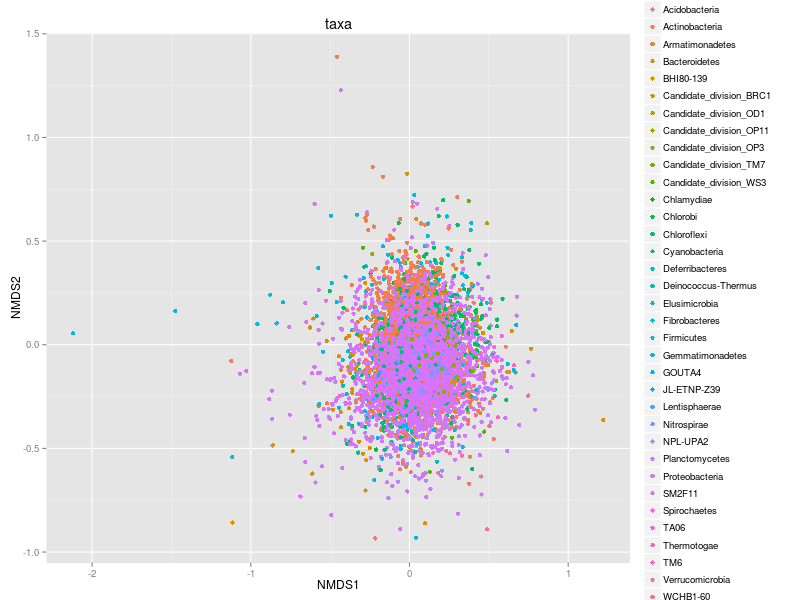

In [76]:
%%R -w 800 -h 600

pp.ord <- ordinate(physeq.plant, "NMDS", "bray")
p1 = plot_ordination(physeq.plant, pp.ord, type = "taxa", color = "Rank2", title = "taxa")
print(p1)

In [92]:
%%R -w 800 -h 600
ordu = ordinate(physeq.plant, "PCoA", "unifrac", weighted = TRUE)


Error in eval(expr, envir, enclos) : object 'Axis1' not found


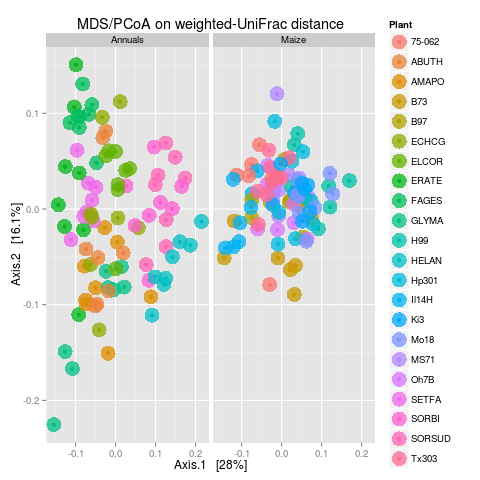

In [97]:
%%R
p = plot_ordination(physeq.plant, ordu, color = "Plant")
p = p + geom_point(size = 7, alpha = 0.75)
p = p + facet_wrap(~Maize)
p + ggtitle("MDS/PCoA on weighted-UniFrac distance")

##NMDS of plant only w-UNIF

In [100]:
%%R -w 800 -h 350


nmds = ordinate(physeq.plant, 
                method = "NMDS", 
               distance = plant.wunif.dist)

p = plot_ordination(physeq.plant, nmds, justDF = TRUE)

Run 0 stress 0.1714023 
Run 1 stress 0.1738922 
Run 2 stress 0.1965102 
Run 3 stress 0.1742783 
Run 4 stress 0.1771153 
Run 5 stress 0.2173716 
Run 6 stress 0.2268373 
Run 7 stress 0.170826 
... New best solution
... procrustes: rmse 0.01955101  max resid 0.2531785 
Run 8 stress 0.1881036 
Run 9 stress 0.2328896 
Run 10 stress 0.1927346 
Run 11 stress 0.1896127 
Run 12 stress 0.1886127 
Run 13 stress 0.1845288 
Run 14 stress 0.1893899 
Run 15 stress 0.1802661 
Run 16 stress 0.1914393 
Run 17 stress 0.1858207 
Run 18 stress 0.1708129 
... New best solution
... procrustes: rmse 0.0005977487  max resid 0.007147874 
*** Solution reached


In [98]:
%%R
colnames(sample_data(physeq.plant))

 [1] "X.sample"            "Library"             "Primer_Plate"       
 [4] "Primer_Well_ID"      "primerFR_ID_byPlate" "primerFR_ID_total"  
 [7] "barcode_ID"          "PlotID"              "Plant"              
[10] "Plot"                "Treatment"           "Rep"                
[13] "DAP"                 "Sampling"            "PlantSample"        
[16] "Type"                "Grass_Broad"         "Status"             
[19] "Subfamily"           "fwd_barcode"         "rev_barcode"        
[22] "BX_rel"              "CB_rel"              "LAP_rel"            
[25] "NAG_rel"             "BX_activity_g"       "CB_activity_g"      
[28] "LAP_activity_g"      "NAG_activity_g"      "BX_bare_factor"     
[31] "CB_bare_factor"      "LAP_bare_factor"     "NAG_bare_factor"    
[34] "BX_dif"              "CB_dif"              "LAP_dif"            
[37] "NAG_dif"             "Moisture"            "PO_Activity"        
[40] "PER_Activity"        "PO.barefactor"       "PER.barefactor"     
[43] "

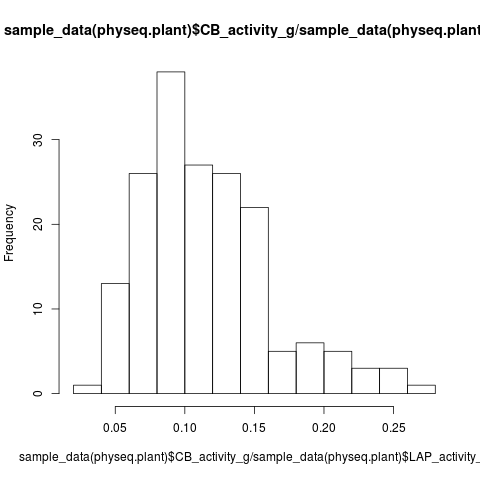

In [118]:
%%R
hist(sample_data(physeq.plant)$CB_activity_g/sample_data(physeq.plant)$LAP_activity_g, bin = .25)

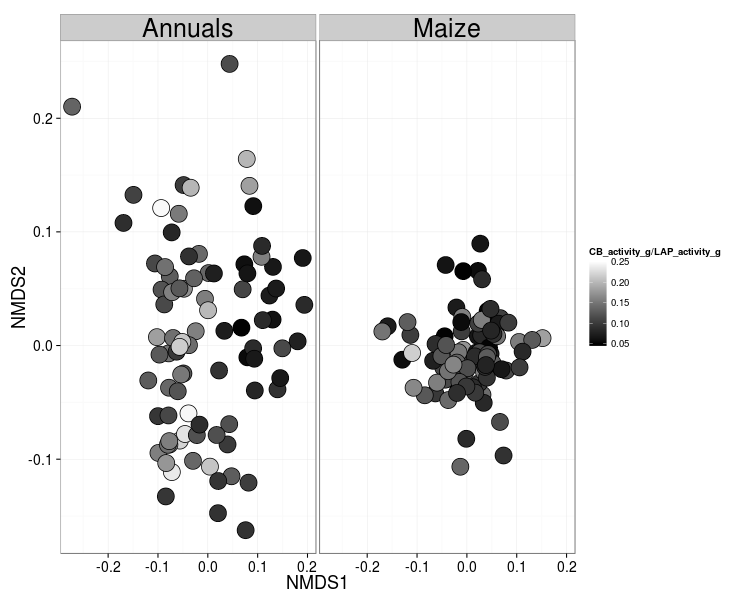

In [119]:
%%R -w 750 -h 600


# generating plot with enzyme activity of LAP as coloring 
p1 = ggplot(p, aes(x = NMDS1, y = NMDS2)) +
        #geom_point(aes(color=LAP_dif), size = 8, pch=21)+
        geom_point(size = 8, pch = 21, aes(fill = CB_activity_g/LAP_activity_g)) +
        scale_fill_gradient(limits=c(.05,.25), low = "black", high = "white")+
        facet_wrap(~Maize) +
        theme_bw() +
        theme(axis.text = element_text(size = 14), 
              axis.title = element_text(size = 18),
             strip.text = element_text(size=25))
        #labs(title = "nMDS w-UniFrac Distances", size = 20)

p1

In [131]:
%%R
PP.rda

Call: rda(formula = OTU ~ BX_dif + CB_dif + LAP_dif + NAG_dif + PO_dif,
data = data)

               Inertia Proportion Rank
Total         0.004335   1.000000     
Constrained   0.000297   0.068600    5
Unconstrained 0.004037   0.931400  170
Inertia is variance 

Eigenvalues for constrained axes:
     RDA1      RDA2      RDA3      RDA4      RDA5 
1.423e-04 6.058e-05 4.785e-05 3.397e-05 1.258e-05 

Eigenvalues for unconstrained axes:
      PC1       PC2       PC3       PC4       PC5       PC6       PC7       PC8 
0.0007090 0.0005164 0.0004240 0.0003508 0.0003272 0.0002572 0.0002147 0.0001449 
(Showed only 8 of all 170 unconstrained eigenvalues)



In [133]:
%%R
PP.rda

Call: rda(formula = OTU ~ BX_dif * CB_dif * LAP_dif * NAG_dif * PO_dif,
data = data)

               Inertia Proportion Rank
Total         0.004335   1.000000     
Constrained   0.000957   0.220700   31
Unconstrained 0.003378   0.779300  144
Inertia is variance 

Eigenvalues for constrained axes:
      RDA1       RDA2       RDA3       RDA4       RDA5       RDA6       RDA7 
0.00025686 0.00014570 0.00011488 0.00010462 0.00007301 0.00005096 0.00004440 
      RDA8       RDA9      RDA10      RDA11      RDA12      RDA13      RDA14 
0.00002483 0.00002373 0.00001901 0.00001515 0.00001129 0.00000929 0.00000802 
     RDA15      RDA16      RDA17      RDA18      RDA19      RDA20      RDA21 
0.00000734 0.00000616 0.00000517 0.00000489 0.00000442 0.00000372 0.00000333 
     RDA22      RDA23      RDA24      RDA25      RDA26      RDA27      RDA28 
0.00000312 0.00000275 0.00000250 0.00000224 0.00000193 0.00000185 0.00000162 
     RDA29      RDA30      RDA31 
0.00000145 0.00000132 0.00000127 

Eigenvalu

In [132]:
%%R
PP.rda <- ordinate(physeq.plant~BX_dif*CB_dif*LAP_dif*NAG_dif*PO_dif, "RDA")


In [139]:
%%R
PP.rda

Call: rda(formula = OTU ~ BX_dif * CB_dif * LAP_dif * NAG_dif * PO_dif,
data = data)

               Inertia Proportion Rank
Total         0.004335   1.000000     
Constrained   0.000957   0.220700   31
Unconstrained 0.003378   0.779300  144
Inertia is variance 

Eigenvalues for constrained axes:
      RDA1       RDA2       RDA3       RDA4       RDA5       RDA6       RDA7 
0.00025686 0.00014570 0.00011488 0.00010462 0.00007301 0.00005096 0.00004440 
      RDA8       RDA9      RDA10      RDA11      RDA12      RDA13      RDA14 
0.00002483 0.00002373 0.00001901 0.00001515 0.00001129 0.00000929 0.00000802 
     RDA15      RDA16      RDA17      RDA18      RDA19      RDA20      RDA21 
0.00000734 0.00000616 0.00000517 0.00000489 0.00000442 0.00000372 0.00000333 
     RDA22      RDA23      RDA24      RDA25      RDA26      RDA27      RDA28 
0.00000312 0.00000275 0.00000250 0.00000224 0.00000193 0.00000185 0.00000162 
     RDA29      RDA30      RDA31 
0.00000145 0.00000132 0.00000127 

Eigenvalu

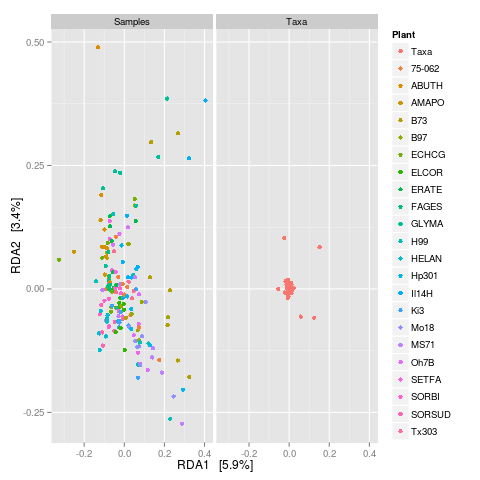

In [138]:
%%R
p5 <- plot_ordination(physeq.plant, PP.rda, type="samples", color="Plant") 
p5

###Beta-diversity hypothesis testing on plant subset 
*Note that maize/non-maize variable should be tested too, for consistency

In [37]:
%%R
df = as(sample_data(physeq.plant), "data.frame")
d = plant.bray.dist
plantadonis = adonis(d ~ Plant + Treatment, df)
plantadonis


Call:
adonis(formula = d ~ Plant + Treatment, data = df) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

           Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)    
Plant      21    8.4563 0.40268  4.8872 0.39718  0.001 ***
Treatment   1    0.2281 0.22808  2.7682 0.01071  0.001 ***
Residuals 153   12.6063 0.08239         0.59210           
Total     175   21.2906                 1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [39]:
%%R
#Compare bray to w-unifrac
df = as(sample_data(physeq.plant), "data.frame")
d = plant.wunif.dist
plantadonis = adonis(d ~ Plant + Treatment, df)
plantadonis


Call:
adonis(formula = d ~ Plant + Treatment, data = df) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

           Df SumsOfSqs  MeanSqs F.Model      R2 Pr(>F)    
Plant      21    2.1909 0.104326  7.6683 0.50625  0.001 ***
Treatment   1    0.0552 0.055205  4.0578 0.01276  0.001 ***
Residuals 153    2.0815 0.013605         0.48099           
Total     175    4.3276                  1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


*Note: what OTUs are influenced by fertilization treatment?

In [19]:
%%R
plant_group = get_variable(physeq.plant, "Plant")
d = plant.wunif.dist
ano1 = anosim(d, plant_group)
summary(ano1)


Call:
anosim(dat = d, grouping = plant_group) 
Dissimilarity: 

ANOSIM statistic R: 0.5935 
      Significance: 0.001 

Permutation: free
Number of permutations: 999

Upper quantiles of permutations (null model):
   90%    95%  97.5%    99% 
0.0225 0.0285 0.0363 0.0428 

Dissimilarity ranks between and within classes:
         0%     25%    50%      75%  100%     N
Between   2 4132.75 7935.5 11671.25 15400 14784
75-062   42  375.50 1026.0  3040.75  8062    28
ABUTH    66 2489.75 6486.5 12922.25 15128    28
AMAPO    16  938.50 2736.0  5022.25 13028    28
B73     107  876.00 3643.0  9604.00 12055    28
B97      34  903.25 1534.5  4489.75  8921    28
ECHCG    24 4880.00 8172.5 12648.25 14618    28
ELCOR    37  486.00 1685.5  3987.25 10575    28
ERATE    18  712.75 2074.5  5171.25 14206    28
FAGES     1   16.25   75.5   317.75  2169    28
GLYMA   497 4290.75 8761.0 11616.00 15076    28
H99      69 1149.50 2812.0  4430.50  6081    28
HELAN    78 1033.75 1727.0  2865.25  8425    28
Hp301  

### Beta-diversity hypothesis tests on just maize

In [20]:
%%R
sample_data(physeq.plant) %>% colnames

 [1] "X.sample"            "Library"             "Primer_Plate"       
 [4] "Primer_Well_ID"      "primerFR_ID_byPlate" "primerFR_ID_total"  
 [7] "barcode_ID"          "PlotID"              "Plant"              
[10] "Plot"                "Treatment"           "Rep"                
[13] "DAP"                 "Sampling"            "PlantSample"        
[16] "Type"                "Grass_Broad"         "Status"             
[19] "Subfamily"           "fwd_barcode"         "rev_barcode"        
[22] "BX_rel"              "CB_rel"              "LAP_rel"            
[25] "NAG_rel"             "BX_activity_g"       "CB_activity_g"      
[28] "LAP_activity_g"      "NAG_activity_g"      "BX_bare_factor"     
[31] "CB_bare_factor"      "LAP_bare_factor"     "NAG_bare_factor"    
[34] "BX_dif"              "CB_dif"              "LAP_dif"            
[37] "NAG_dif"             "Moisture"            "PO_Activity"        
[40] "PER_Activity"        "PO.barefactor"       "PER.barefactor"     
[43] "

In [90]:
%%R

physeq.maize = subset_samples(physeq.thresh, Type == "Maize")
physeq.maize

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 6736 taxa and 88 samples ]
sample_data() Sample Data:       [ 88 samples by 46 sample variables ]
tax_table()   Taxonomy Table:    [ 6736 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 6736 tips and 6735 internal nodes ]


In [91]:
%%R
registerDoParallel(cores=28)

maize.wunif.dist = phyloseq::distance(physeq.maize, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

Run 0 stress 0.1769837 
Run 1 stress 0.2128006 
Run 2 stress 0.1966768 
Run 3 stress 0.2123581 
Run 4 stress 0.1819005 
Run 5 stress 0.1946274 
Run 6 stress 0.2040355 
Run 7 stress 0.1849688 
Run 8 stress 0.1992297 
Run 9 stress 0.2006831 
Run 10 stress 0.179523 
Run 11 stress 0.186153 
Run 12 stress 0.1835567 
Run 13 stress 0.1956851 
Run 14 stress 0.179185 
Run 15 stress 0.1819701 
Run 16 stress 0.2035755 
Run 17 stress 0.196273 
Run 18 stress 0.1973563 
Run 19 stress 0.2191087 
Run 20 stress 0.1816849 


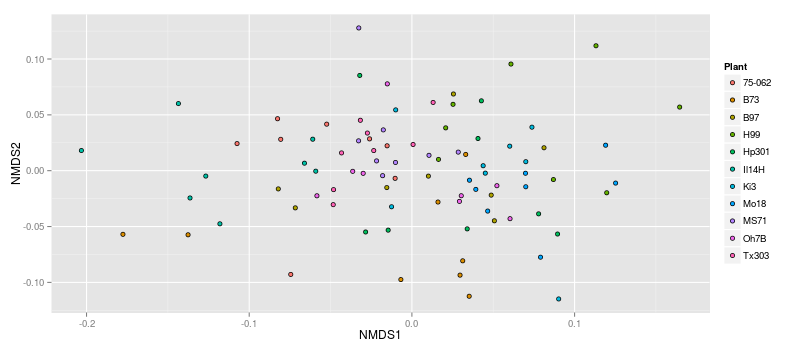

In [92]:
%%R -w 800 -h 350


nmds = ordinate(physeq.thresh, 
                method = "NMDS", 
                distance = maize.wunif.dist)

p = plot_ordination(physeq.thresh, nmds, justDF = TRUE)


## generating plots
p1 = ggplot(p, aes(x = NMDS1, y = NMDS2)) +
        geom_point(aes(fill=Plant), pch = 21)
        #scale_size(range=c(2,8))

#p2 = ggplot(p, aes(x = NMDS1, y = NMDS2)) +
        #geom_point(aes(fill=Plant, size = BD), pch=21) +
        #scale_size(range=c(2,8))

grid.arrange(p1, ncol=1)

In [94]:
%%R
df = as(sample_data(physeq.maize), "data.frame")
d = maize.wunif.dist
plantadonis = adonis(d ~ Plant + Treatment, df)
plantadonis


Call:
adonis(formula = d ~ Plant + Treatment, data = df) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

          Df SumsOfSqs  MeanSqs F.Model      R2 Pr(>F)    
Plant     10   0.54231 0.054231  4.6177 0.37126  0.001 ***
Treatment  1   0.02587 0.025874  2.2031 0.01771  0.031 *  
Residuals 76   0.89256 0.011744         0.61103           
Total     87   1.46075                  1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [25]:
%%R
plant_group = get_variable(physeq.maize, "Plant")
d = maize.wunif.dist
ano1 = anosim(d, plant_group)
summary(ano1)


Call:
anosim(dat = d, grouping = plant_group) 
Dissimilarity: 

ANOSIM statistic R: 0.3979 
      Significance: 0.001 

Permutation: free
Number of permutations: 999

Upper quantiles of permutations (null model):
   90%    95%  97.5%    99% 
0.0299 0.0395 0.0482 0.0611 

Dissimilarity ranks between and within classes:
        0%     25%    50%     75% 100%    N
Between  1 1039.75 1989.5 2929.25 3828 3520
75-062  25  270.25  673.0 1617.00 3016   28
B73     74  588.00 1851.5 3303.75 3629   28
B97     20  605.50  940.5 2136.00 3193   28
H99     45  742.75 1532.5 2125.00 2593   28
Hp301   68 1120.75 1749.5 2482.75 3251   28
Il14H    7  729.00 1188.5 2387.00 3034   28
Ki3     27  259.00  897.5 1501.25 3106   28
Mo18     4  563.00  869.5 1507.00 2663   28
MS71     2   76.50  348.0  911.25 2506   28
Oh7B     6  183.00 1304.5 1812.00 2745   28
Tx303   23  226.75  391.5  632.75 2053   28



#Test correlation between enzyme activity and microbial community composition

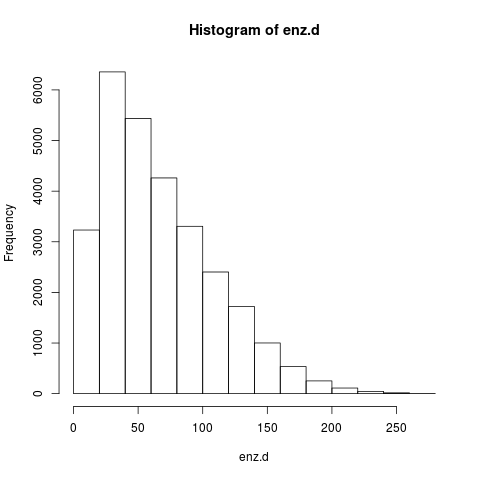

In [26]:
%%R
Sd = sample_data(physeq)
enz.d = dist(Sd[,26:29], method = "euclidian")
hist(enz.d)

In [27]:
%%R
M1 = mantel(full.wunif.dist, enz.d, method="pearson", permutations=999)
M1


Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = full.wunif.dist, ydis = enz.d, method = "pearson",      permutations = 999) 

Mantel statistic r: 0.1025 
      Significance: 0.002 

Upper quantiles of permutations (null model):
   90%    95%  97.5%    99% 
0.0298 0.0413 0.0510 0.0640 
Permutation: free
Number of permutations: 999



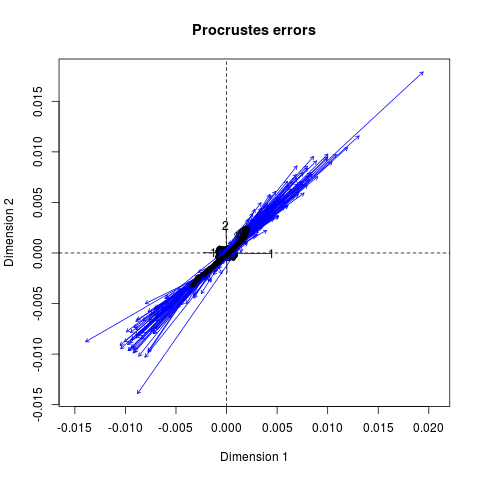

In [28]:
%%R
 p1 = protest(full.wunif.dist, enz.d, scores = "sites", permutations = 999)
plot(p1)

###Test if variation with plants is correlated with variation between plant microbial community

$breaks
 [1]   0  20  40  60  80 100 120 140 160 180 200 220 240 260

$counts
 [1] 1849 3455 2847 2329 1765 1292  933  512  235  115   47   18    3

$density
 [1] 6.003247e-03 1.121753e-02 9.243506e-03 7.561688e-03 5.730519e-03
 [6] 4.194805e-03 3.029221e-03 1.662338e-03 7.629870e-04 3.733766e-04
[11] 1.525974e-04 5.844156e-05 9.740260e-06

$mids
 [1]  10  30  50  70  90 110 130 150 170 190 210 230 250

$xname
[1] "enz.d"

$equidist
[1] TRUE

attr(,"class")
[1] "histogram"

Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = plant.wunif.dist, ydis = enz.d, method = "pearson",      permutations = 999) 

Mantel statistic r: 0.1032 
      Significance: 0.003 

Upper quantiles of permutations (null model):
   90%    95%  97.5%    99% 
0.0462 0.0567 0.0664 0.0790 
Permutation: free
Number of permutations: 999



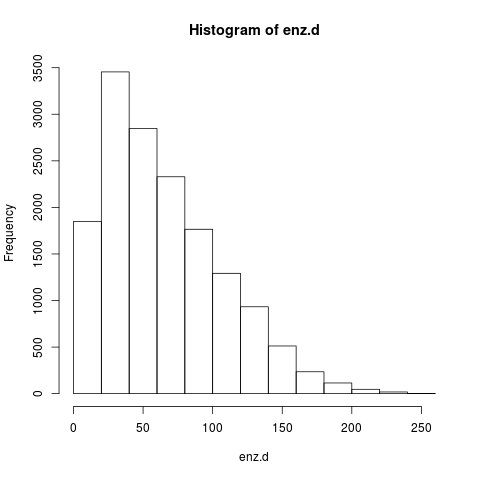

In [96]:
%%R
Sd = sample_data(physeq.plant)

enz.d = dist(Sd[,c(26:29)], method = "euclidian")

hist(enz.d) %>% print

M1 = mantel(plant.wunif.dist, enz.d, method="pearson", permutations=999)
M1 %>% print


In [30]:
%%R
colnames(Sd)

 [1] "X.sample"            "Library"             "Primer_Plate"       
 [4] "Primer_Well_ID"      "primerFR_ID_byPlate" "primerFR_ID_total"  
 [7] "barcode_ID"          "PlotID"              "Plant"              
[10] "Plot"                "Treatment"           "Rep"                
[13] "DAP"                 "Sampling"            "PlantSample"        
[16] "Type"                "Grass_Broad"         "Status"             
[19] "Subfamily"           "fwd_barcode"         "rev_barcode"        
[22] "BX_rel"              "CB_rel"              "LAP_rel"            
[25] "NAG_rel"             "BX_activity_g"       "CB_activity_g"      
[28] "LAP_activity_g"      "NAG_activity_g"      "BX_bare_factor"     
[31] "CB_bare_factor"      "LAP_bare_factor"     "NAG_bare_factor"    
[34] "BX_dif"              "CB_dif"              "LAP_dif"            
[37] "NAG_dif"             "Moisture"            "PO_Activity"        
[40] "PER_Activity"        "PO.barefactor"       "PER.barefactor"     
[43] "

In [95]:
%%R
Sd = sample_data(physeq.maize)
enz.d = dist(Sd[,c(26:29)], method = "euclidian")
M1 = mantel(maize.wunif.dist, enz.d, method="pearson", permutations=999)
M1 %>% print



Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = maize.wunif.dist, ydis = enz.d, method = "pearson",      permutations = 999) 

Mantel statistic r: 0.01947 
      Significance: 0.332 

Upper quantiles of permutations (null model):
   90%    95%  97.5%    99% 
0.0660 0.0844 0.1013 0.1185 
Permutation: free
Number of permutations: 999



In [52]:
%%R
colnames(sample_data(plant.T50))

 [1] "X.sample"            "Library"             "Primer_Plate"       
 [4] "Primer_Well_ID"      "primerFR_ID_byPlate" "primerFR_ID_total"  
 [7] "barcode_ID"          "PlotID"              "Plant"              
[10] "Plot"                "Treatment"           "Rep"                
[13] "DAP"                 "Sampling"            "PlantSample"        
[16] "Type"                "Grass_Broad"         "Status"             
[19] "Subfamily"           "fwd_barcode"         "rev_barcode"        
[22] "BX_rel"              "CB_rel"              "LAP_rel"            
[25] "NAG_rel"             "BX_activity_g"       "CB_activity_g"      
[28] "LAP_activity_g"      "NAG_activity_g"      "BX_bare_factor"     
[31] "CB_bare_factor"      "LAP_bare_factor"     "NAG_bare_factor"    
[34] "BX_dif"              "CB_dif"              "LAP_dif"            
[37] "NAG_dif"             "Moisture"            "PO_Activity"        
[40] "PER_Activity"        "PO.barefactor"       "PER.barefactor"     
[43] "

*Notes: once we are comparing among plants the microbial community is a predictor of enzyme activity, but not the rhizosphere effect on enzyme activity.  

Among maize inbred lines there the microbial community is not significant. 

Consider how to compare log2Fold change to change in enzyme activity



In [51]:
%%R
veganotu = function(physeq) {
    require("vegan")
    OTU = otu_table(physeq)
    if (taxa_are_rows(OTU)) {
        OTU = t(OTU)
    }
    return(as(OTU, "matrix"))
}

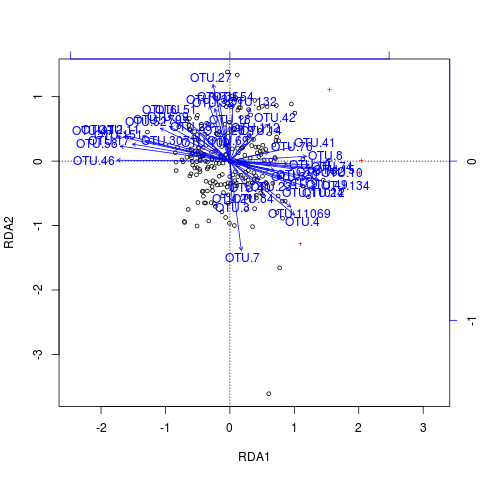

In [59]:
%%R
#Redundancy analysis between enzyme and microbial community
#1) subset microbial community to top 50 OTUs in plant treatment
plant.T50 = prune_taxa(names(sort(taxa_sums(physeq.thresh),TRUE)[1:50]), physeq.thresh)
#tax_table(plant.T50)
colnames(sample_data(plant.T50))
#2) run on non-transformed enzyme bare factors
R1 = rda(sample_data(plant.T50)[,34:37], veganotu(plant.T50), scale=TRUE)
plot(R1)